In [10]:
import pandas as pd
import numpy as np
import os
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
import seaborn as sns
import matplotlib.pyplot as plt
# from prophet import Prophet

In [33]:
def make_weather_plots(df:pd.DataFrame, feature:str)-> None:
    print(f'Plotting values for {feature}')
    sns.lineplot(df[feature]).set(title=f'Line graph of data for {feature}')
    plt.show()
    # sns.lineplot(y=df[feature], x= df.index.round('h')).set(title=f'Line graph of mean over hour hour for {feature}')
    # plt.show()
    sns.lineplot(y=df[feature], x= df.index.round('d')).set(title=f'Line graph of mean over day for {feature}')
    plt.show()
    sns.lineplot(y=df[feature], x= df.index.month_name()).set(title=f'Line graph of mean over month for {feature}')
    plt.show()
    
    if feature == 'Rain':
        sns.barplot(y=df[feature], x= df.index.hour).set(title=f'Barplot by hour of day for {feature}', xlabel='Hour of day')
        plt.show()
        sns.barplot(y=df[feature], x= df.index.month_name()).set(title=f'Barplot by month of year for {feature}', xlabel='Month of year')
        plt.show()
    else:
        sns.boxplot(y=df[feature], x= df.index.hour).set(title=f'Boxplot by hour of day for {feature}', xlabel='Hour of day')
        plt.show()
        sns.boxplot(y=df[feature], x= df.index.month_name()).set(title=f'Boxplot by month of year for {feature}', xlabel='Month of year')
        plt.show()
    print('Plotting for hour')
    decomp_res = seasonal_decompose(df[feature].resample('1h').mean().interpolate(method='nearest').fillna(method='ffill'))
    decomp_res.plot();
    result = adfuller(decomp_res.resid.dropna())
    print(f'The test statistic is {result[0]}')
    print(f'The p value is {result[1]}')
    plt.show()
    plot_acf(decomp_res.resid.dropna());
    plt.show()
    plot_pacf(decomp_res.resid.dropna());
    plt.show()
    print('Plotting for day')
    decomp_res = seasonal_decompose(df[feature].resample('1d').mean().interpolate(method='nearest').fillna(method='ffill'))
    decomp_res.plot();
    result = adfuller(decomp_res.resid.dropna())
    print(f'The test statistic is {result[0]}')
    print(f'The p value is {result[1]}')
    plt.show()
    plot_acf(decomp_res.resid.dropna());
    plt.show()
    plot_pacf(decomp_res.resid.dropna());
    plt.show()
    

In [40]:
def plot_missing(df: pd.DataFrame):
    temp = df.melt(id_vars='team', ignore_index=False).reset_index()
    temp['is_na'] = temp['value'].isna()
    fig:sns.FacetGrid = sns.relplot(data = temp, y='is_na', x='datetime', hue='team',  col='variable', col_wrap=3, alpha=0.7, kind='line')
    fig.tick_params('x', labelrotation=30)
    plt.show()

In [4]:
def make_plots(df:pd.DataFrame, feature:str)-> None:
    temp = df.reset_index()
    print(f'Plotting values for {feature}')
    sns.lineplot(y = temp[feature], x=temp['datetime'], hue=temp['team'] ).set(title=f'Line graph of data for {feature}')
    plt.xticks(rotation=30)
    plt.show()
    if pd.Series(df.index).diff().mode()[0] < pd.Timedelta(10, 'minute'):
        # sns.lineplot(y=temp[feature], x=temp['datetime'].dt.round('h'), hue=temp['team'] ).set(title=f'Line graph of mean over hour hour for {feature}')
        # plt.xticks(rotation=30)
        # plt.show()
        sns.lineplot(y=temp[feature], x=temp['datetime'].dt.round('d'), hue=temp['team']).set(title=f'Line graph of mean over day for {feature}')
        plt.xticks(rotation=30)
        plt.show()
    sns.lineplot(y = temp[feature], x=temp['datetime'].dt.month_name(), hue=temp['team']).set(title=f'Line graph of mean over month for {feature}')
    plt.xticks(rotation=30)
    plt.show()
    if pd.Series(df.index).diff().mode()[0] < pd.Timedelta(10, 'minute'):
        sns.boxplot(y = temp[feature], x=temp['datetime'].dt.hour, hue=temp['team']).set(title=f'Boxplot by hour of day for {feature}', xlabel='Hour of day')
        plt.xticks(rotation=30)
        plt.show()
    sns.boxplot(y = temp[feature], x=temp['datetime'].dt.month_name(), hue=temp['team']).set(title=f'Boxplot by month of year for {feature}', xlabel='Month of year')
    plt.xticks(rotation=30)
    plt.show()

# Weather

## Main observations:

- Most of the radiation based features: `PARout`, `Iglob`, `RadSum`, `Tout` have a strong 24 hour seasonality and increase from the winter months (December) to Summer (May)
- `Pyrgeo` also shows similar trend, but the values get more negative the hotter it gets (more energy is being emitted)
- Lots of rain in February, not so much in May (`Rain` is binary, and I'm not sure how to do time series analysis for binary data)
- Based on the values of `AbsHumOut`, `Rhout` and `Rain`. The place where data was collected has dry summers
- `AbsHumOut` seems to have a strong negative autocorrelation.
- `Rhout` seems to have a 24 hour seasonality, might be due to `Tout`
- `Windsp` has 24 hour seasonality, seems to be very high in February
- All the values seem to be missing at the same time, not really sure why

## Code

In [5]:
weather  = pd.read_csv(os.path.join('..','data', 'AutonomousGreenhouseChallenge_edition2','Weather', 'Weather.csv'))
weather['datetime'] = pd.to_datetime(weather['%time'], unit='D', origin='1899-12-30')
weather = weather.set_index('datetime', drop=True)
weather = weather.drop(columns=['%time'])

<AxesSubplot: xlabel='datetime', ylabel='value'>

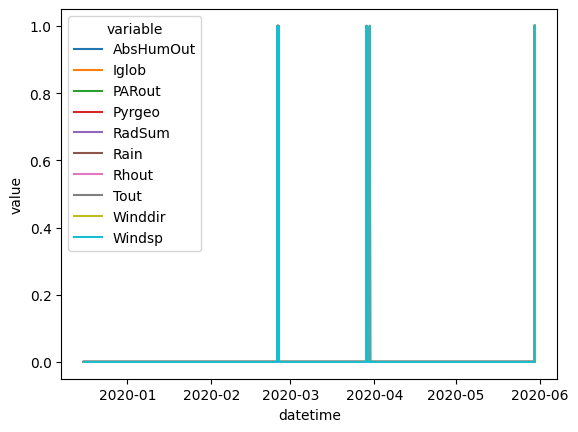

In [6]:
sns.lineplot(y=weather.melt(ignore_index=False)['value'].isna(), x=weather.melt(ignore_index=False).index,  hue=weather.melt(ignore_index=False)['variable'], )

In [ ]:
for feat in weather.columns:
    make_weather_plots(weather, feat)


# Crop Parameters

## Main Observations

* The data is collected weekly, hence there aren't that many data points. And many of the quantities are supposed to increase over time anyway, and so it is difficult to distinguish the effects of trend and seasonality
* In my opinion, the most important quantity here, `Cum_trusses` increases steadily over time for all the teams, so I think they are all doing quite well.
* Plant density (number of plants per square meter) remains same throughout, so no new plants are planted
* Stem density increases though, not sure how that's calculated

## Code

In [35]:
crop_param = pd.DataFrame()
for file in glob.glob('..\data\AutonomousGreenhouseChallenge_edition2\*\CropParameters.csv'):
    sub_crop_param = pd.read_csv(file) 
    sub_crop_param['datetime'] = pd.to_datetime(sub_crop_param['%Time'], unit='D', origin='1899-12-30')
    sub_crop_param = sub_crop_param.set_index('datetime', drop=True)
    sub_crop_param = sub_crop_param.drop(columns=['%Time'])
    for col in sub_crop_param.columns:
        sub_crop_param[col] = pd.to_numeric(sub_crop_param[col], errors='coerce')
    sub_crop_param['team'] = file.split('\\')[-2]
    crop_param = pd.concat([crop_param, sub_crop_param])

print(crop_param.shape)
display(crop_param)

(138, 6)


,Stem_elong,Stem_thick,Cum_trusses,stem_dens,plant_dens,team
datetime,,,,,,
2019-12-24,18.7,8.3,NaN,3.6,1.8,AICU
2019-12-31,29.9,11.7,1.3,3.6,1.8,AICU
2020-01-08,35.8,13.6,3.2,3.6,1.8,AICU
2020-01-15,35.1,13.5,4.7,3.6,1.8,AICU
2020-01-22,34.7,12.6,5.8,3.6,1.8,AICU
...,...,...,...,...,...,...
2020-04-29,NaN,NaN,23.8,5.4,1.8,TheAutomators
2020-05-06,NaN,NaN,NaN,5.4,1.8,TheAutomators
2020-05-13,NaN,NaN,NaN,5.4,1.8,TheAutomators


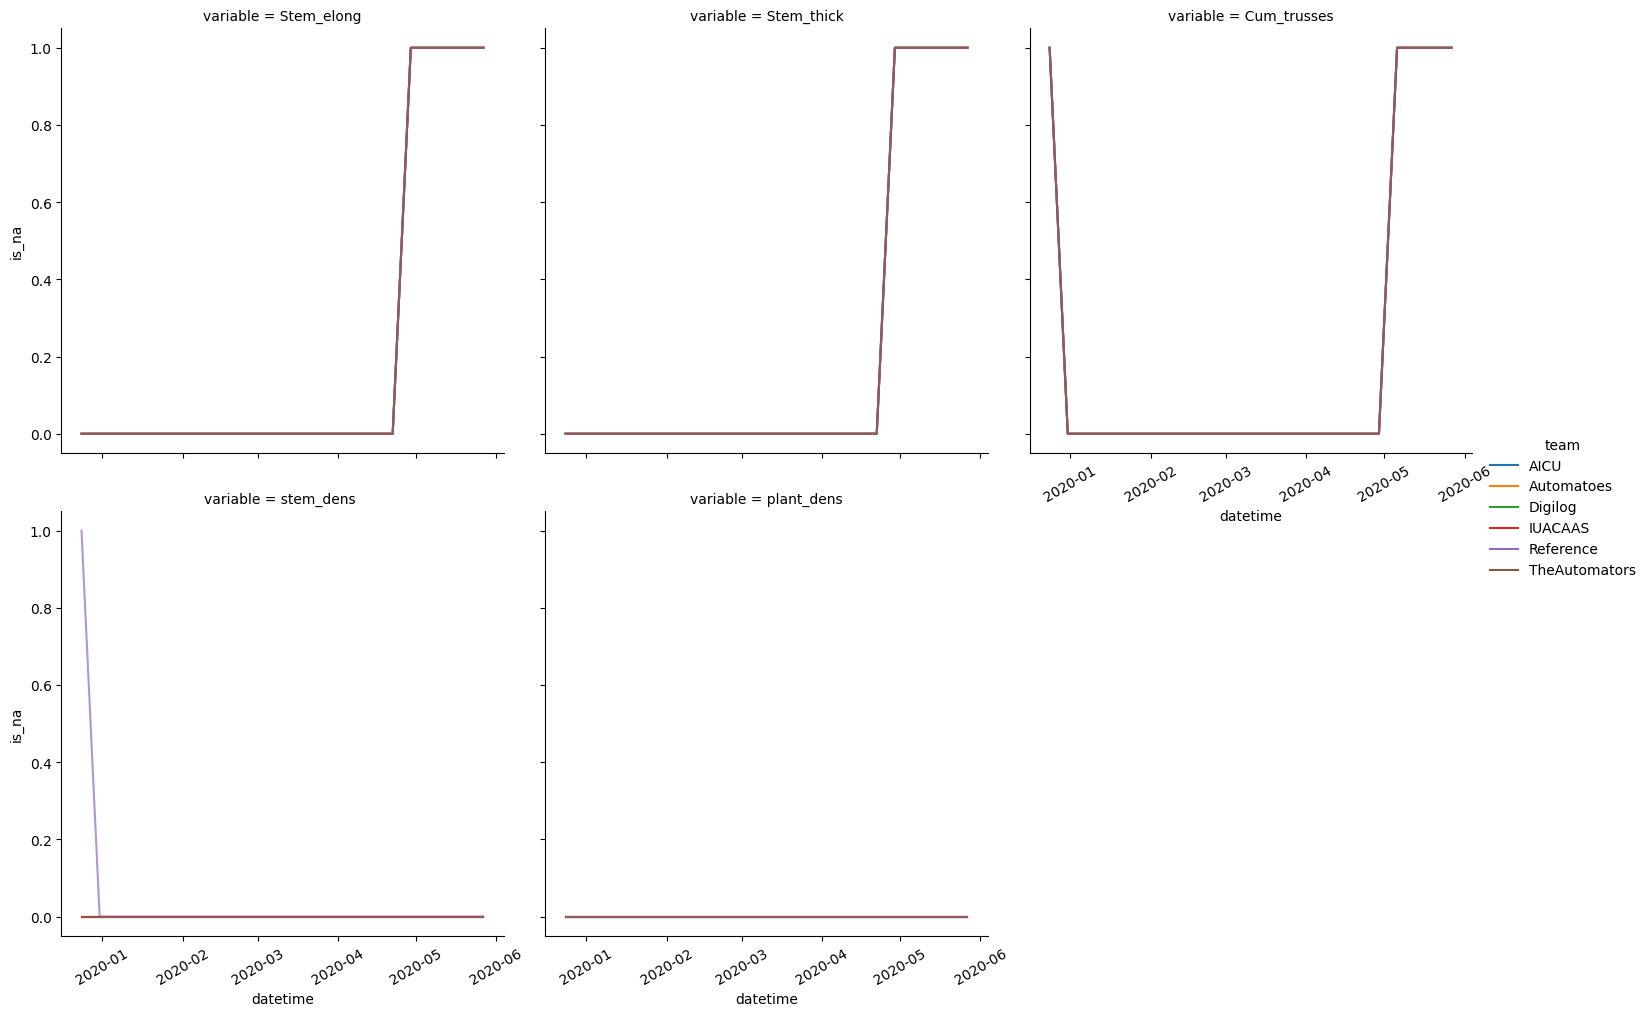

In [41]:
plot_missing(crop_param)

Plotting values for Stem_elong


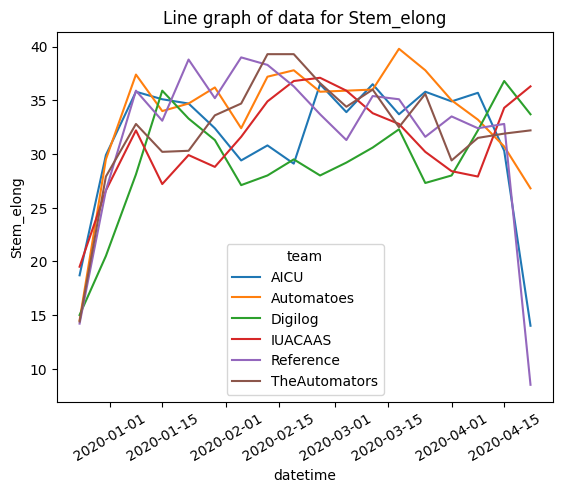

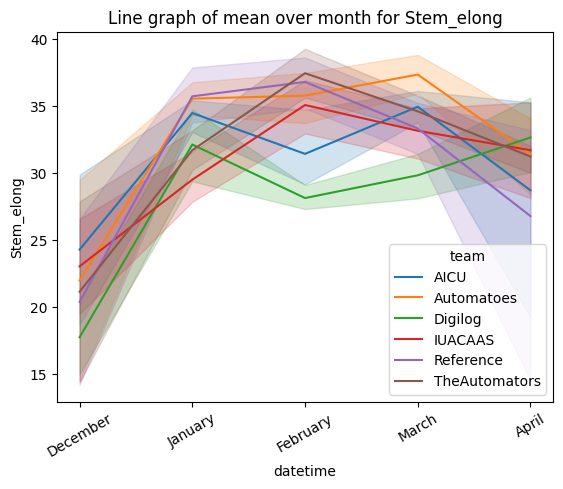

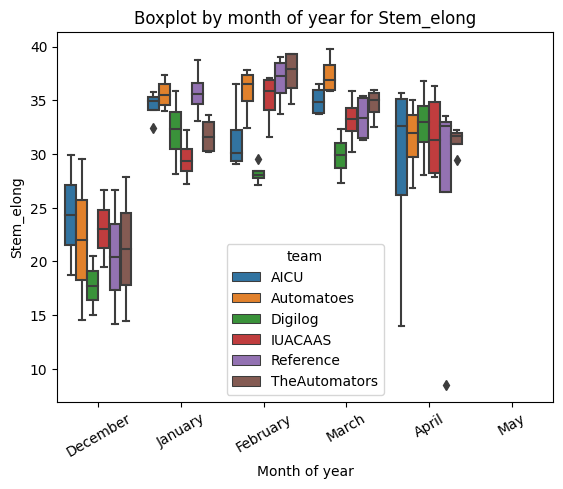

Plotting values for Stem_thick


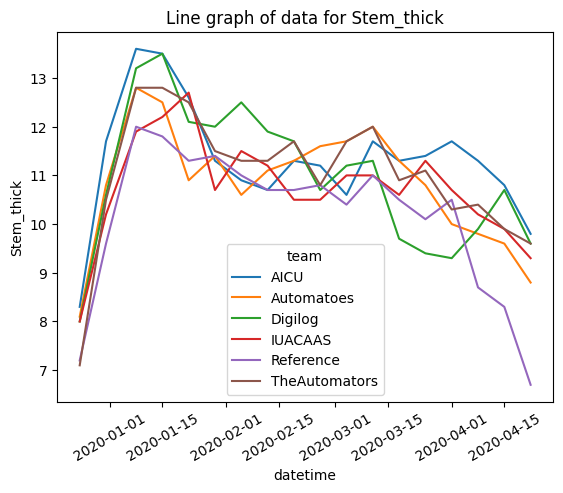

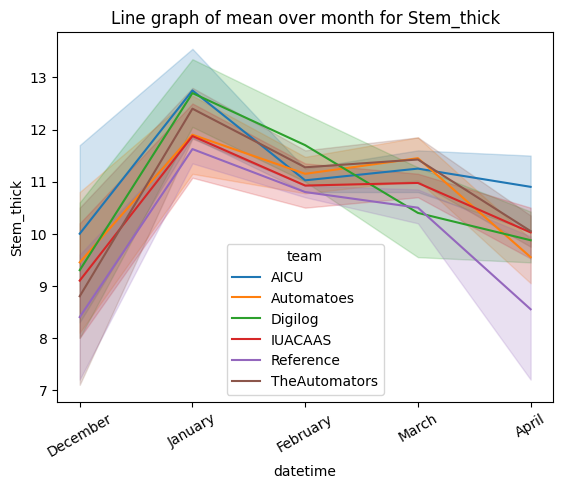

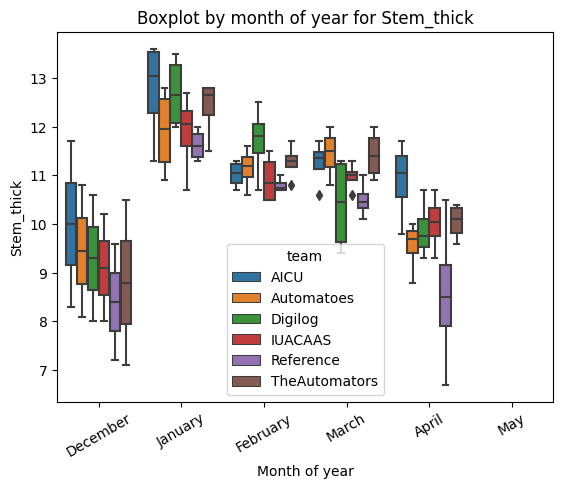

Plotting values for Cum_trusses


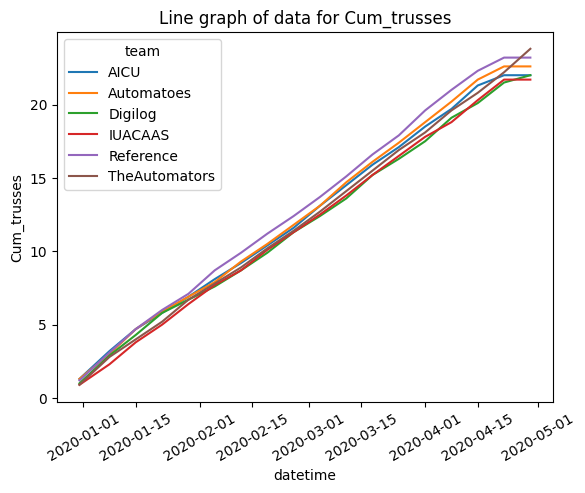

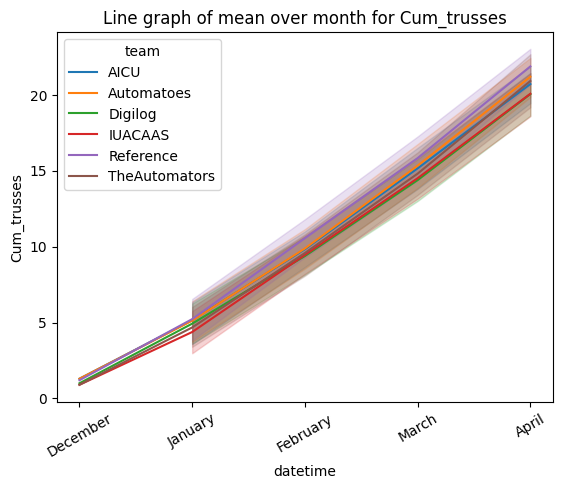

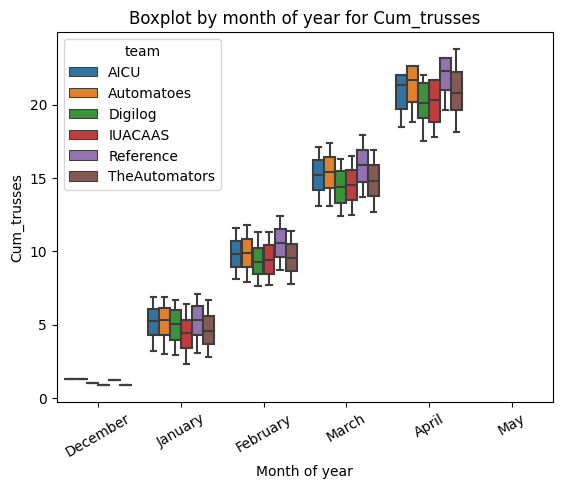

Plotting values for stem_dens 


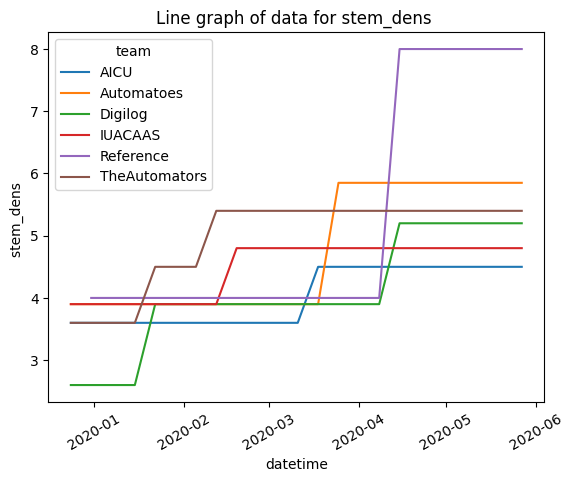

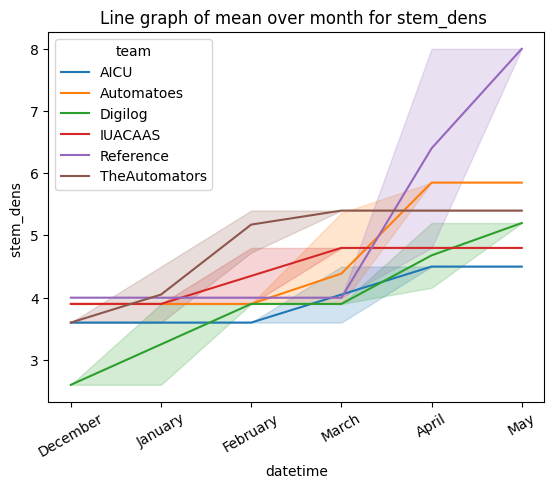

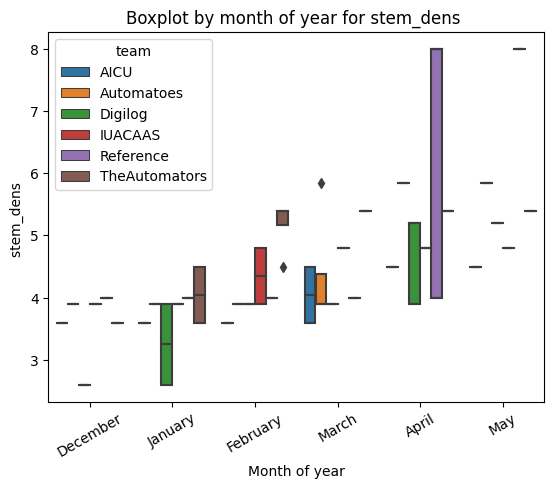

Plotting values for plant_dens


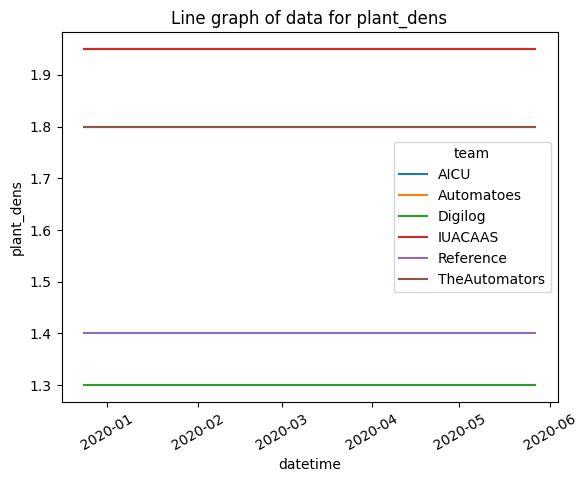

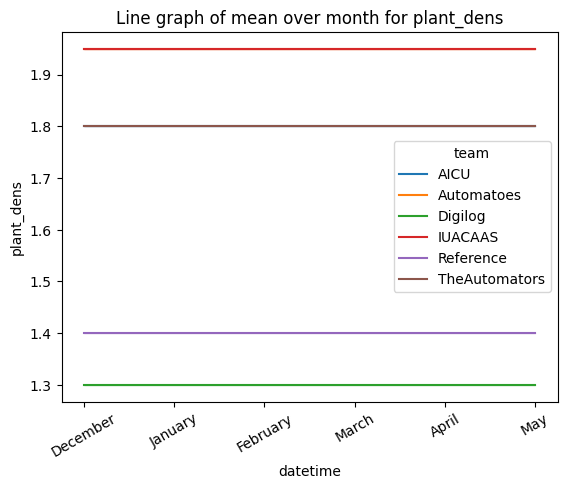

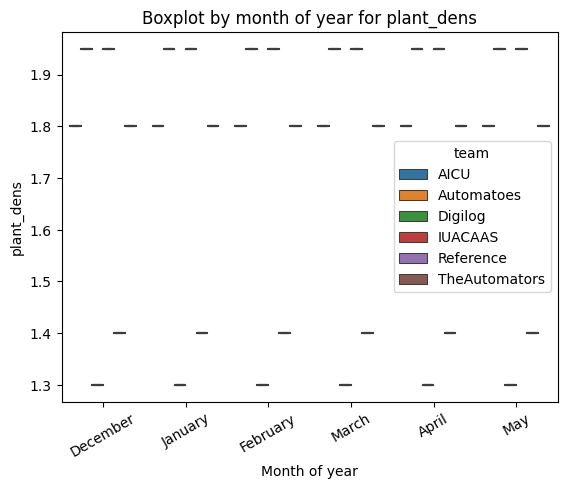

In [37]:
for col in crop_param.columns:
    if col !='team':
        make_plots(crop_param, col)

In [ ]:
# crop_prarm = pd.read_csv('..\data\AutonomousGreenhouseChallenge_edition2\Reference\CropParameters.csv') 
# crop_prarm['datetime'] = pd.to_datetime(crop_prarm['%Time'], unit='D', origin='1899-12-30')
# crop_prarm = crop_prarm.set_index('datetime', drop=True)
# crop_prarm = crop_prarm.drop(columns=['%Time'])

# for col in crop_prarm.columns:
#     crop_prarm[col] = pd.to_numeric(crop_prarm[col], errors='coerce')
#     sns.lineplot(crop_prarm[col]).set(title=f'line graph for {col}')
#     plt.xticks(rotation=45)
#     plt.show()

# Greenhouse Climate

In [ ]:
green_climate = pd.DataFrame()
for file in glob.glob('..\data\AutonomousGreenhouseChallenge_edition2\*\GreenhouseClimate.csv'):
    sub_green_climate = pd.read_csv(file) 
    sub_green_climate['datetime'] = pd.to_datetime(sub_green_climate['%time'], unit='D', origin='1899-12-30')
    sub_green_climate = sub_green_climate.set_index('datetime', drop=True)
    sub_green_climate = sub_green_climate.drop(columns=['%time'])
    for col in sub_green_climate.columns:
        sub_green_climate[col] = pd.to_numeric(sub_green_climate[col], errors='coerce')
    sub_green_climate['team'] = file.split('\\')[-2]
    green_climate = pd.concat([green_climate, sub_green_climate])

print(green_climate.shape)
display(green_climate)

In [ ]:
plot_missing(green_climate)

In [ ]:
for col in green_climate.columns:
    if col != 'team':
        make_plots(green_climate, col)

In [ ]:
# green_climate = pd.read_csv('..\data\AutonomousGreenhouseChallenge_edition2\Reference\GreenhouseClimate.csv', dtype=str)
# for col in green_climate.columns:
#     green_climate[col] = pd.to_numeric(green_climate[col], errors='coerce')
    
# green_climate['datetime'] = pd.to_datetime(green_climate['%time'], unit='D', origin='1899-12-30')
# green_climate = green_climate.set_index('datetime', drop=True)
# green_climate = green_climate.drop(columns=['%time'])

In [ ]:
# for col in green_climate.columns:
#     sns.lineplot(green_climate[col]).set(title=f'Line graph as is for {col}')
#     plt.show()
#     sns.lineplot(y=green_climate[col], x= green_climate.index.round('h')).set(title=f'Line graph by hour for {col}')
#     plt.show()
#     sns.lineplot(y=green_climate[col], x= green_climate.index.round('d')).set(title=f'Line graph by day for {col}')
#     plt.show()
#     sns.boxplot(y=green_climate[col], x= green_climate.index.hour).set(title=f'Boxplot by hour of day for {col}')
#     plt.show()
#     sns.boxplot(y=green_climate[col], x= green_climate.index.month_name()).set(title=f'Boxplot by month of year for {col}')
#     plt.show()
#     # sns.lineplot(green_climate[col]).set(title=f'Plot for {col}')
#     # plt.show()

# Grodan Sens

In [ ]:
grodan_sens = pd.DataFrame()
for file in glob.glob('..\data\AutonomousGreenhouseChallenge_edition2\*\GrodanSens.csv'):
    sub_grodan_sens = pd.read_csv(file) 
    sub_grodan_sens['datetime'] = pd.to_datetime(sub_grodan_sens['%time'], unit='D', origin='1899-12-30')
    sub_grodan_sens = sub_grodan_sens.set_index('datetime', drop=True)
    sub_grodan_sens = sub_grodan_sens.drop(columns=['%time'])
    for col in sub_grodan_sens.columns:
        sub_grodan_sens[col] = pd.to_numeric(sub_grodan_sens[col], errors='coerce')
    sub_grodan_sens['team'] = file.split('\\')[-2]
    grodan_sens = pd.concat([grodan_sens, sub_grodan_sens])

print(grodan_sens.shape)
display(grodan_sens.head())

In [ ]:
plot_missing(grodan_sens)

In [ ]:
for col in grodan_sens.columns:
    if col != 'team':
        make_plots(grodan_sens, col)

In [ ]:
# grodan_sens = pd.read_csv('..\data\AutonomousGreenhouseChallenge_edition2\Reference\GrodanSens.csv') 
# for col in grodan_sens.columns:
#     grodan_sens[col] = pd.to_numeric(grodan_sens[col], errors='coerce')
# grodan_sens['datetime'] = pd.to_datetime(grodan_sens['%time'], unit='D', origin='1899-12-30')
# grodan_sens = grodan_sens.set_index('datetime', drop=True)
# grodan_sens = grodan_sens.drop(columns=['%time'])

In [ ]:
# for col in grodan_sens.columns:
#     sns.lineplot(grodan_sens[col]).set(title=f'Line graph as is for {col}')
#     plt.show()
#     sns.lineplot(y=grodan_sens[col], x= grodan_sens.index.round('h')).set(title=f'Line graph by hour for {col}')
#     plt.show()
#     sns.lineplot(y=grodan_sens[col], x= grodan_sens.index.round('d')).set(title=f'Line graph by day for {col}')
#     plt.show()
#     sns.boxplot(y=grodan_sens[col], x= grodan_sens.index.hour).set(title=f'Boxplot by hour of day for {col}')
#     plt.show()
#     sns.boxplot(y=grodan_sens[col], x= grodan_sens.index.month_name()).set(title=f'Boxplot by month of year for {col}')
#     plt.show()

# Lab analysis

In [ ]:
lab_analysis = pd.DataFrame()
for file in glob.glob('..\data\AutonomousGreenhouseChallenge_edition2\*\LabAnalysis.csv'):
    sub_lab_analysis = pd.read_csv(file) 
    sub_lab_analysis['datetime'] = pd.to_datetime(sub_lab_analysis['%Time'], unit='D', origin='1899-12-30')
    sub_lab_analysis = sub_lab_analysis.set_index('datetime', drop=True)
    sub_lab_analysis = sub_lab_analysis.drop(columns=['%Time'])
    for col in sub_lab_analysis.columns:
        sub_lab_analysis[col] = pd.to_numeric(sub_lab_analysis[col], errors='coerce')
    sub_lab_analysis['team'] = file.split('\\')[-2]
    lab_analysis = pd.concat([lab_analysis, sub_lab_analysis])

print(lab_analysis.shape)
display(lab_analysis.head())

In [ ]:
# plot_missing(lab_analysis)
lab_analysis.isna().sum()[lab_analysis.isna().sum()>0]

In [ ]:
for col in lab_analysis.columns:
    if col != 'team':
        make_plots(lab_analysis, col)

In [ ]:
# lab_analysis = pd.read_csv('..\data\AutonomousGreenhouseChallenge_edition2\Reference\LabAnalysis.csv') 
# lab_analysis['datetime'] = pd.to_datetime(lab_analysis['%Time'], unit='D', origin='1899-12-30')
# lab_analysis = lab_analysis.set_index('datetime', drop=True)
# lab_analysis = lab_analysis.drop(columns=['%Time'])
# lab_analysis = lab_analysis.melt(ignore_index=False)
# lab_analysis['sample_source'], lab_analysis['quantity_measured'] =lab_analysis['variable'].str.split('_').apply(lambda x:x[0]), lab_analysis['variable'].str.split('_').apply(lambda x:x[1])
# lab_analysis = lab_analysis.drop(columns=['variable'])
# lab_analysis = lab_analysis.reset_index()
# lab_analysis = lab_analysis.pivot(columns=[ 'quantity_measured'], values=['value',], index=['datetime','sample_source']).droplevel(0, axis=1).reset_index(level=1 )
# lab_analysis

In [ ]:
# for col in lab_analysis.columns:
#     if col != 'sample_source':
#         sns.lineplot(y=lab_analysis[col], x=lab_analysis.index, hue=lab_analysis['sample_source']).set(title=f'Line graph as is for {col}')
#         plt.xticks(rotation=45)
#         plt.show()
#         sns.boxplot(y=lab_analysis[col], x= lab_analysis.index.month_name(), hue=lab_analysis['sample_source']).set(title=f'Boxplot by month of year for {col}')
#         plt.xticks(rotation=45)
#         plt.show()

# Production

In [ ]:
prod = pd.DataFrame()
for file in glob.glob('..\data\AutonomousGreenhouseChallenge_edition2\*\GrodanSens.csv'):
    sub_prod = pd.read_csv(file) 
    sub_prod['datetime'] = pd.to_datetime(sub_prod['%time'], unit='D', origin='1899-12-30')
    sub_prod = sub_prod.set_index('datetime', drop=True)
    sub_prod = sub_prod.drop(columns=['%time'])
    for col in sub_prod.columns:
        sub_prod[col] = pd.to_numeric(sub_prod[col], errors='coerce')
    sub_prod['team'] = file.split('\\')[-2]
    prod = pd.concat([prod, sub_prod])

print(prod.shape)
display(prod.head())

In [ ]:
plot_missing(prod)

In [ ]:
for col in prod.columns:
    if col != 'team':
        make_plots(prod, col)

In [ ]:
# prod = pd.read_csv('..\data\AutonomousGreenhouseChallenge_edition2\Reference\Production.csv') 

# prod['datetime'] = pd.to_datetime(prod['%time'], unit='D', origin='1899-12-30')
# prod = prod.set_index('datetime', drop=True)
# prod = prod.drop(columns=['%time'])

# prod

In [ ]:
# for col in prod.columns:
#     sns.lineplot(y=prod[col], x=prod.index).set(title=f'Line graph as is for {col}')
#     plt.xticks(rotation=45)
#     plt.show()
#     sns.boxplot(y=prod[col], x= prod.index.month_name()).set(title=f'Boxplot by month of year for {col}')
#     plt.xticks(rotation=45)
#     plt.show()

# Resources

In [ ]:
resources = pd.DataFrame()
for file in glob.glob('..\data\AutonomousGreenhouseChallenge_edition2\*\GrodanSens.csv'):
    sub_resources = pd.read_csv(file) 
    sub_resources['datetime'] = pd.to_datetime(sub_resources['%time'], unit='D', origin='1899-12-30')
    sub_resources = sub_resources.set_index('datetime', drop=True)
    sub_resources = sub_resources.drop(columns=['%time'])
    for col in sub_resources.columns:
        sub_resources[col] = pd.to_numeric(sub_resources[col], errors='coerce')
    sub_resources['team'] = file.split('\\')[-2]
    resources = pd.concat([resources, sub_resources])

print(resources.shape)
display(resources.head())

In [ ]:
plot_missing(resources)

In [ ]:
for col in resources.columns:
    if col != 'team':
        make_plots(resources, col)

In [ ]:
# resources = pd.read_csv('..\data\AutonomousGreenhouseChallenge_edition2\Reference\Resources.csv') 
# resources['datetime'] = pd.to_datetime(resources['%Time '], unit='D', origin='1899-12-30')
# resources = resources.set_index('datetime', drop=True)
# resources = resources.drop(columns=['%Time '])
# resources

In [ ]:
# for col in resources.columns:
#     sns.lineplot(y=resources[col], x=resources.index).set(title=f'Line graph as is for {col}')
#     plt.xticks(rotation=45)
#     plt.show()
#     sns.boxplot(y=resources[col], x= resources.index.month_name()).set(title=f'Boxplot by month of year for {col}')
#     plt.xticks(rotation=45)
#     plt.show()

# Tom Quality

In [ ]:
tom_quality = pd.DataFrame()
for file in glob.glob('..\data\AutonomousGreenhouseChallenge_edition2\*\TomQuality.csv'):
    sub_tom_quality = pd.read_csv(file, sep=',', engine='python', skiprows=1, header=None, names=['%time', 'Flavor', 'TSS', 'Acid', '%Juice', 'Bite','Weight','DMC_Fruit']) 
    # sub_tom_quality.columns = [col.strip(', ') for col in sub_tom_quality.columns]
    sub_tom_quality['datetime'] = pd.to_datetime(sub_tom_quality['%time'], unit='D', origin='1899-12-30')
    sub_tom_quality = sub_tom_quality.set_index('datetime', drop=True)
    sub_tom_quality = sub_tom_quality.drop(columns=['%time'])
    for col in sub_tom_quality.columns:
        if sub_tom_quality[col].dtype == 'O':
            sub_tom_quality[col] = pd.to_numeric(sub_tom_quality[col].str.replace(',', ''), errors='coerce')
    sub_tom_quality['team'] = file.split('\\')[-2]
    tom_quality = pd.concat([tom_quality, sub_tom_quality])

print(tom_quality.shape)
display(tom_quality.head())

In [ ]:
plot_missing(tom_quality)

In [ ]:
for col in tom_quality.columns:
    if col != 'team':
        make_plots(tom_quality, col)

In [ ]:
# tom_quality = pd.read_csv('..\data\AutonomousGreenhouseChallenge_edition2\Reference\TomQuality.csv', sep='\t', engine='python')
# tom_quality.columns = [col.strip(', ') for col in tom_quality.columns]
# for col in tom_quality.columns:
#     if tom_quality[col].dtype == 'O':
#         tom_quality[col] = pd.to_numeric(tom_quality[col].str.replace(',', ''), errors='coerce')
# tom_quality['datetime'] = pd.to_datetime(tom_quality['%time'], unit='D', origin='1899-12-30')
# tom_quality = tom_quality.set_index('datetime', drop=True)
# tom_quality = tom_quality.drop(columns=['%time'])
# tom_quality

In [ ]:
# for col in tom_quality.columns:
#     sns.lineplot(y=tom_quality[col], x=tom_quality.index).set(title=f'Line graph as is for {col}')
#     plt.xticks(rotation=45)
#     plt.show()
#     sns.boxplot(y=tom_quality[col], x= tom_quality.index.month_name()).set(title=f'Boxplot by month of year for {col}')
#     plt.xticks(rotation=45)
#     plt.show()